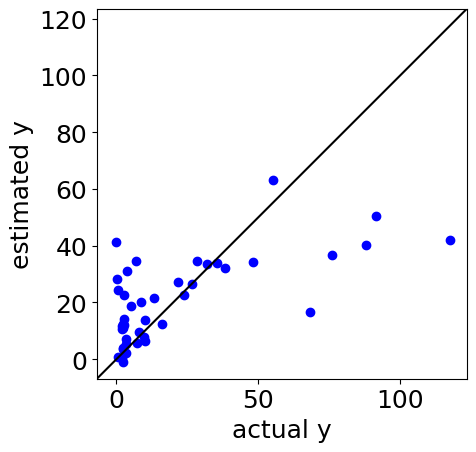

r^2 for training data : 0.41754302117670583
RMSE for training data : 21.710492597857456
MAE for training data : 13.74148858485671


/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamaza

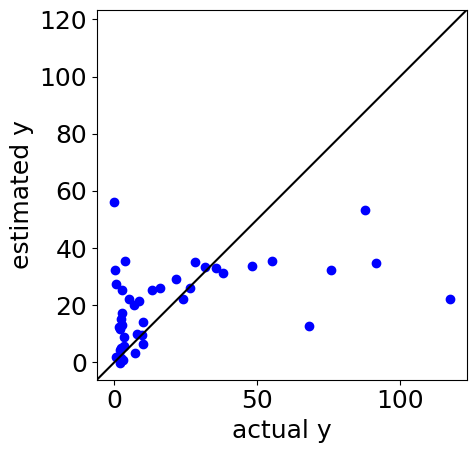

r^2 in cross-validation : 0.21040839032721903
RMSE in cross-validation : 25.277784860207664
MAE in cross-validation : 15.925277248824571
     std_of_estimated_y
4             23.846962
7             24.361373
8             24.736194
11            24.382699
13            23.618046
..                  ...
724           30.878996
725           31.006568
726           31.446848
727           31.024742
728           31.053591

[686 rows x 1 columns]
sample number : 1 / 30
     std_of_estimated_y
4             23.486800
7             24.036249
8             24.466249
11            24.042732
13            23.314752
..                  ...
724           30.804467
725           30.966614
726           31.354472
727           30.957146
728           31.024328

[685 rows x 1 columns]
sample number : 2 / 30
     std_of_estimated_y
4             23.281807
7             23.773620
8             24.162103
11            23.823456
13            23.035659
..                  ...
724           30.253601
7

In [3]:
import os
import numpy as np

#次の候補の数
number_of_selecting_samples = 30

# ファイルのパスを定義
generated_samples_path = './../data/generated_samples.csv'
remaining_samples_path = './../data/remaining_samples2.csv'

# 実験結果データの読み込み
dataset = pd.read_csv('./../data/result_20231207.csv', index_col=0, header=0)

if os.path.exists(remaining_samples_path):
    x_prediction = pd.read_csv(remaining_samples_path, index_col=0, header=0)
elif os.path.exists(generated_samples_path):
    x_prediction = pd.read_csv(generated_samples_path, index_col=0, header=0)


# 実験条件の全候補のインデックスのリスト
all_indexes = x_prediction.index.tolist()

# データ分割
y = dataset.iloc[:, 0]  # 目的変数
x = dataset.iloc[:, 1:]  # 説明変数

# 標準偏差が 0 の特徴量の削除
deleting_variables = x.columns[x.std() == 0]
x = x.drop(deleting_variables, axis=1)
x_prediction = x_prediction.drop(deleting_variables, axis=1)
cumulative_variance = np.zeros(x_prediction.shape[0]) # MI で必要な "ばらつき" を 0 で初期化

# ガウス過程回帰(最初にカーネル関数を選択する)
regression_method = 'gpr_one_kernel'
acquisition_function = "PTR" #PTR PI EI MI

cumulative_variance = np.zeros(x_prediction.shape[0]) # MI で必要な "ばらつき" を 0 で初期化
relaxation = 0.01 #EI PI
delta = 10**-6 #MI

next_samples = pd.DataFrame([], columns=x_prediction.columns) # 次のサンプルを入れる変数を準備

for sample_number in range(number_of_selecting_samples):
    # オートスケーリング
    autoscaled_y = (y - y.mean()) / y.std()
    autoscaled_x = (x - x.mean()) / x.std()
    autoscaled_x_prediction = (x_prediction - x.mean()) / x.std()

    # モデル構築
    model = gpr_one_kernel(2,autoscaled_x, autoscaled_y, x)

     # クロスバリデーション
    if sample_number == 0:
        validate = validate_model(regression_method, model,10, autoscaled_x, autoscaled_y, x, y)

    # 予測
    estimated_y_prediction, estimated_y_prediction_std = predict(regression_method, model, autoscaled_x_prediction, x_prediction, y)

    estimated_y_prediction, acquisition_function_prediction, acquisition_function = acquisition_functions(x_prediction, estimated_y_prediction, estimated_y_prediction_std, delta, acquisition_function, relaxation, y, regression_method)


    # 保存
    estimated_y_prediction = pd.DataFrame(estimated_y_prediction, x_prediction.index, columns=['estimated_y'])
    estimated_y_prediction_std = pd.DataFrame(estimated_y_prediction_std, x_prediction.index, columns=['std_of_estimated_y'])
    print(estimated_y_prediction_std)
    acquisition_function_prediction = pd.DataFrame(acquisition_function_prediction, index=x_prediction.index, columns=['acquisition_function'])
    if sample_number == 0:
        estimated_y_prediction.to_csv('./../data/estimated_y_prediction_{0}.csv'.format(regression_method))  # 予測結果を csv ファイルに保存。同じ名前のファイルがあるときは上書きされる
        estimated_y_prediction_std.to_csv('./../data/estimated_y_prediction_{0}_std.csv'.format(regression_method))  # 予測値の標準偏差を csv ファイルに保存。同じ名前のファイルがあるときは上書きされる
        acquisition_function_prediction.to_csv('./../data/acquisition_function_prediction_{0}_{1}.csv'.format(regression_method, acquisition_function))  # 獲得関数を csv ファイルに保存。同じ名前のファイルがあるときは上書きされる

    # 次のサンプル
    next_samples = pd.concat([next_samples, x_prediction.loc[acquisition_function_prediction.idxmax()]], axis=0)
    
    
    # x, y, x_prediction, cumulative_variance の更新
    x = pd.concat([x, x_prediction.loc[acquisition_function_prediction.idxmax()]], axis=0)
    y = pd.concat([y, estimated_y_prediction.loc[acquisition_function_prediction.idxmax()].iloc[0]], axis=0)
    x_prediction = x_prediction.drop(acquisition_function_prediction.idxmax(), axis=0)
    cumulative_variance = np.delete(cumulative_variance, np.where(acquisition_function_prediction.index == acquisition_function_prediction.iloc[:, 0].idxmax())[0][0])
    print('sample number : {0} / {1}'.format(sample_number + 1, number_of_selecting_samples))

# 実験日の日付
date = "2023-12-07"
x_prediction.to_csv('./../data/remaining_samples3.csv')
next_samples.to_csv(f'./../data/next_samples_bo_{date}.csv'.format(regression_method, acquisition_function)) # csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, ConstantKernel, Matern, DotProduct
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import norm


def gpr_one_kernel(kernel_number,autoscaled_x, autoscaled_y,x):
    # カーネル 11 種類
    kernels = [ConstantKernel() * DotProduct() + WhiteKernel(),
            ConstantKernel() * RBF() + WhiteKernel(),
            ConstantKernel() * RBF() + WhiteKernel() + ConstantKernel() * DotProduct(),
            ConstantKernel() * RBF(np.ones(x.shape[1])) + WhiteKernel(),
            ConstantKernel() * RBF(np.ones(x.shape[1])) + WhiteKernel() + ConstantKernel() * DotProduct(),
            ConstantKernel() * Matern(nu=1.5) + WhiteKernel(),
            ConstantKernel() * Matern(nu=1.5) + WhiteKernel() + ConstantKernel() * DotProduct(),
            ConstantKernel() * Matern(nu=0.5) + WhiteKernel(),
            ConstantKernel() * Matern(nu=0.5) + WhiteKernel() + ConstantKernel() * DotProduct(),
            ConstantKernel() * Matern(nu=2.5) + WhiteKernel(),
            ConstantKernel() * Matern(nu=2.5) + WhiteKernel() + ConstantKernel() * DotProduct()]

    selected_kernel = kernels[kernel_number]
    model = GaussianProcessRegressor(alpha=0, kernel=selected_kernel)
    model.fit(autoscaled_x, autoscaled_y)

    return model





def validate_model(regression_method, model,fold_number, autoscaled_x, autoscaled_y, x, y):
     # クロスバリデーションの fold 数
    fold_number = fold_number
    
    # トレーニングデータの推定(実験データ)
    autoscaled_estimated_y = model.predict(autoscaled_x)  # y の推定
    estimated_y = autoscaled_estimated_y * y.std() + y.mean()  # スケールをもとに戻す
    estimated_y = pd.DataFrame(estimated_y, index=x.index, columns=['estimated_y'])

    # トレーニングデータの実測値 vs. 推定値のプロット
    plt.rcParams['font.size'] = 18
    plt.scatter(y, estimated_y.iloc[:, 0], c='blue')  # 実測値 vs. 推定値プロット
    y_max = max(y.max(), estimated_y.iloc[:, 0].max())  # 実測値の最大値と、推定値の最大値の中で、より大きい値を取得
    y_min = min(y.min(), estimated_y.iloc[:, 0].min())  # 実測値の最小値と、推定値の最小値の中で、より小さい値を取得
    plt.plot([y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
            [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], 'k-')  # 取得した最小値-5%から最大値+5%まで、対角線を作成
    plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))  # y 軸の範囲の設定
    plt.xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))  # x 軸の範囲の設定
    plt.xlabel('actual y')  # x 軸の名前
    plt.ylabel('estimated y')  # y 軸の名前
    plt.gca().set_aspect('equal', adjustable='box')  # 図の形を正方形に
    plt.show()  # 以上の設定で描画

    # トレーニングデータのr2, RMSE, MAE
    print('r^2 for training data :', r2_score(y, estimated_y))
    print('RMSE for training data :', mean_squared_error(y, estimated_y, squared=False))
    print('MAE for training data :', mean_absolute_error(y, estimated_y))

    # トレーニングデータの結果の保存
    y_for_save = pd.DataFrame(y)
    y_for_save.columns = ['actual_y']
    y_error_train = y_for_save.iloc[:, 0] - estimated_y.iloc[:, 0]
    y_error_train = pd.DataFrame(y_error_train)
    y_error_train.columns = ['error_of_y(actual_y-estimated_y)']
    results_train = pd.concat([y_for_save, estimated_y, y_error_train], axis=1) # 結合
    results_train.to_csv('./../results/validation/estimated_y_in_detail_{0}.csv'.format(regression_method))  # 推定値を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください
    
    # クロスバリデーションによる y の値の推定
    cross_validation = KFold(n_splits=fold_number, random_state=9, shuffle=True) # クロスバリデーションの分割の設定
    autoscaled_estimated_y_in_cv = cross_val_predict(model, autoscaled_x, autoscaled_y, cv=cross_validation)  # y の推定
    estimated_y_in_cv = autoscaled_estimated_y_in_cv * y.std() + y.mean()  # スケールをもとに戻す
    estimated_y_in_cv = pd.DataFrame(estimated_y_in_cv, index=x.index, columns=['estimated_y'])

    # クロスバリデーションにおける実測値 vs. 推定値のプロット
    plt.rcParams['font.size'] = 18
    plt.scatter(y, estimated_y_in_cv.iloc[:, 0], c='blue')  # 実測値 vs. 推定値プロット
    y_max = max(y.max(), estimated_y_in_cv.iloc[:, 0].max())  # 実測値の最大値と、推定値の最大値の中で、より大きい値を取得
    y_min = min(y.min(), estimated_y_in_cv.iloc[:, 0].min())  # 実測値の最小値と、推定値の最小値の中で、より小さい値を取得
    plt.plot([y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
            [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], 'k-')  # 取得した最小値-5%から最大値+5%まで、対角線を作成
    plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))  # y 軸の範囲の設定
    plt.xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))  # x 軸の範囲の設定
    plt.xlabel('actual y')  # x 軸の名前
    plt.ylabel('estimated y')  # y 軸の名前
    plt.gca().set_aspect('equal', adjustable='box')  # 図の形を正方形に
    plt.show()  # 以上の設定で描画

    # クロスバリデーションにおけるr2, RMSE, MAE
    print('r^2 in cross-validation :', r2_score(y, estimated_y_in_cv))
    print('RMSE in cross-validation :', mean_squared_error(y, estimated_y_in_cv, squared=False))
    print('MAE in cross-validation :', mean_absolute_error(y, estimated_y_in_cv))

    # クロスバリデーションの結果の保存
    y_error_in_cv = y_for_save.iloc[:, 0] - estimated_y_in_cv.iloc[:, 0]
    y_error_in_cv = pd.DataFrame(y_error_in_cv)
    y_error_in_cv.columns = ['error_of_y(actual_y-estimated_y)']
    results_in_cv = pd.concat([y_for_save, estimated_y_in_cv, y_error_in_cv], axis=1) # 結合
    results_in_cv.to_csv('./../results/validation/estimated_y_in_cv_in_detail_{0}.csv'.format(regression_method))  # 推定値を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください
    


    

def predict(regression_method, model, autoscaled_x_prediction, x_prediction, y):
    estimated_y_prediction_std = None

    if regression_method == 'gpr_one_kernel' or regression_method == 'gpr_kernels':  # 標準偏差あり
        estimated_y_prediction, estimated_y_prediction_std = model.predict(
            autoscaled_x_prediction, return_std=True)
        estimated_y_prediction_std = estimated_y_prediction_std * y.std()
        estimated_y_prediction_std = pd.DataFrame(
            estimated_y_prediction_std, x_prediction.index, columns=['std_of_estimated_y'])
        estimated_y_prediction_std.to_csv('estimated_y_prediction_{0}_std.csv'.format(
            regression_method))  # 予測値の標準偏差を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください
    else:
        estimated_y_prediction = model.predict(autoscaled_x_prediction)

    estimated_y_prediction = estimated_y_prediction * y.std() + y.mean()
    estimated_y_prediction = pd.DataFrame(
        estimated_y_prediction, x_prediction.index, columns=['estimated_y'])
    estimated_y_prediction.to_csv('estimated_y_prediction_{0}.csv'.format(
        regression_method))  # 予測結果を csv ファイルに保存。

    return estimated_y_prediction, estimated_y_prediction_std



def acquisition_functions(x_prediction, estimated_y_prediction, estimated_y_prediction_std, delta, acquisition_function, relaxation, y, regression_method):
    target_range = [0, 1]  # PTR
    relaxation = 0.01  # EI, PI
    delta = 10 ** -6  # MI

    cumulative_variance = np.zeros(
        x_prediction.shape[0])  # MI で必要な "ばらつき" を 0 で初期化
    if acquisition_function == 'MI':
        acquisition_function_prediction = estimated_y_prediction + np.log(2 / delta) ** 0.5 * (
            (estimated_y_prediction_std ** 2 + cumulative_variance) ** 0.5 - cumulative_variance ** 0.5)
        cumulative_variance = cumulative_variance + estimated_y_prediction_std ** 2
    elif acquisition_function == 'EI':
        acquisition_function_prediction = (estimated_y_prediction - max(y) - relaxation * y.std()) * \
            norm.cdf((estimated_y_prediction - max(y) - relaxation * y.std()) /
                     estimated_y_prediction_std) + \
            estimated_y_prediction_std * \
            norm.pdf((estimated_y_prediction - max(y) - relaxation * y.std()) /
                     estimated_y_prediction_std)
    elif acquisition_function == 'PI':
        acquisition_function_prediction = norm.cdf(
            (estimated_y_prediction - max(y) - relaxation * y.std()) / estimated_y_prediction_std)
    elif acquisition_function == 'PTR':
        acquisition_function_prediction = norm.cdf(target_range[1],
                                                   loc=estimated_y_prediction,
                                                   scale=estimated_y_prediction_std
                                                   ) - norm.cdf(target_range[0],
                                                                loc=estimated_y_prediction,
                                                                scale=estimated_y_prediction_std)
    acquisition_function_prediction[estimated_y_prediction_std <= 0] = 0

    # 保存
    estimated_y_prediction = pd.DataFrame(
        estimated_y_prediction, x_prediction.index, columns=['estimated_y'])
    estimated_y_prediction.to_csv('estimated_y_prediction_{0}.csv'.format(
        regression_method))  # 予測結果を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください
    estimated_y_prediction_std = pd.DataFrame(
        estimated_y_prediction_std, x_prediction.index, columns=['std_of_estimated_y'])
    estimated_y_prediction_std.to_csv('estimated_y_prediction_{0}_std.csv'.format(
        regression_method))  # 予測値の標準偏差を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください
    acquisition_function_prediction = pd.DataFrame(
        acquisition_function_prediction, index=x_prediction.index, columns=['acquisition_function'])
    acquisition_function_prediction.to_csv('acquisition_function_prediction_{0}_{1}.csv'.format(
        regression_method, acquisition_function))  # 獲得関数を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください

    return estimated_y_prediction, acquisition_function_prediction, acquisition_function

